In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
os.chdir(".")
# from parc.data.data import EnergeticMatDataPipeLine as EmData
# from parc import misc, metrics, visualization
# from parc.model import model_hypersonic


2024-03-02 18:54:32.120545: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Data pipeline

In [2]:
import time
import os
import numpy as np
import skimage
from skimage.measure import block_reduce


Re_list = ['1.6', '1.7','1.8', '2.1', '2.2', '2.3', '2.4', '2.6', '2.7', '2.8', '2.9', '3.1', '3.2', '3.3', '3.4', '3.6',
         '3.7', '3.8', '3.9', '4.1', '4.2', '4.3', '4.4', '1.1', '1.2', '1.3', '1.4', '1.5', '2.0', '2.5', '3.0', '3.5',
         '4.0', '4.5', '4.6', '4.7', '4.8', '4.9', '5.0']
def clip_raw_data():
    state_whole = []
    vel_whole = []
    
    for Re in Re_list:
        data_file_name = 'mach_' + Re + '.npy'
#         print(data_file_name)
        file_path = '/scratch/pdy2bw/hypersonic_normalized/' + data_file_name                
        if os.path.exists(file_path):
            raw_data = np.float32(np.load(file_path))[:120,:,:,:]
            # print(raw_data.shape)

            raw_data = raw_data[0::3,:,:,:]
            print(raw_data.shape)

            raw_data = np.moveaxis(raw_data,0,-2)
            state = np.reshape(raw_data[:,:,:,:2], (112,176,80))
            vel = np.reshape(raw_data[:,:,:,2:], (112,176,80))
            # raw_data = skimage.measure.block_reduce(raw_data[:40,:,:,:], (1,2,2,1),np.max)
            
            # print(data_shape)
            # norm_r = Re/1000
            # r_img = norm_r*np.ones(shape = (data_shape[0],data_shape[1],data_shape[2],1))
            # r_whole.extend(raw_data)

            state_whole.append(state)
            vel_whole.append(vel)
    state_whole = np.concatenate([state_whole])
    vel_whole = np.concatenate([vel_whole])

    return state_whole, vel_whole

state_seq, vel_seq = clip_raw_data()



(40, 112, 176, 4)
(40, 112, 176, 4)
(40, 112, 176, 4)
(40, 112, 176, 4)
(40, 112, 176, 4)
(40, 112, 176, 4)
(40, 112, 176, 4)
(40, 112, 176, 4)
(40, 112, 176, 4)
(40, 112, 176, 4)
(40, 112, 176, 4)
(40, 112, 176, 4)
(40, 112, 176, 4)
(40, 112, 176, 4)
(40, 112, 176, 4)
(40, 112, 176, 4)
(40, 112, 176, 4)
(40, 112, 176, 4)
(40, 112, 176, 4)
(40, 112, 176, 4)
(40, 112, 176, 4)
(40, 112, 176, 4)
(40, 112, 176, 4)
(40, 112, 176, 4)
(40, 112, 176, 4)
(40, 112, 176, 4)
(40, 112, 176, 4)
(40, 112, 176, 4)
(40, 112, 176, 4)
(40, 112, 176, 4)
(40, 112, 176, 4)
(40, 112, 176, 4)
(40, 112, 176, 4)
(40, 112, 176, 4)
(40, 112, 176, 4)
(40, 112, 176, 4)
(40, 112, 176, 4)
(40, 112, 176, 4)
(40, 112, 176, 4)


In [3]:
def create_train_data(seq, no_of_fields, sequence_length = 2):
    shape = seq.shape
    num_time_steps = np.int32((shape[-1]-1)/no_of_fields)
    vel_seq_whole = []
#     constant_whole = []
    for i in range(shape[0]):
#         constant = seq[i:i+1,:,:,0:1]
        for j in range(num_time_steps-sequence_length+1):
            vel_seq_case = np.expand_dims(seq[i, :, :, (j*no_of_fields):(j*no_of_fields+sequence_length*no_of_fields)],axis = 0)
#             vel_seq_case = np.concatenate([constant,vel_seq_case],axis = -1)
            vel_seq_whole.extend(vel_seq_case)
    vel_seq_whole = np.concatenate([vel_seq_whole], axis=0)

    return vel_seq_whole

train_state = create_train_data(state_seq[:22,:,:,:], no_of_fields = 2, sequence_length = 2)
train_vel = create_train_data(vel_seq[:22,:,:,:], no_of_fields = 2, sequence_length = 2)

In [4]:
from tensorflow import keras
from tensorflow.keras import  layers, regularizers
from keras.layers import *
import tensorflow as tf
from parc import layer

from tensorflow.keras.layers import Concatenate, Input
from tensorflow.keras.models import Model

"""
Differentiator for hypersonic flow problem: 
    - state vars: density, pressure
    - there is no constant field using
"""
DATA_SHAPE = (112, 176)

def differentiator_em(n_state_var=2):
    # Model initiation
    feature_extraction = layer.feature_extraction_unet(input_shape=DATA_SHAPE,
                                                       n_channel=n_state_var+2)
    
    mapping_and_recon = []
    # rho_dot: n_mask_channel=2 because of advec+diff
    mapping_and_recon.append(layer.mapping_and_recon_cnn(input_shape=DATA_SHAPE,
                                                         n_mask_channel=2, 
                                                         output_channel=1))
    # p_dot: n_mask_channel=1 because of no diffusion
    mapping_and_recon.append(layer.mapping_and_recon_cnn(input_shape=DATA_SHAPE,
                                                         n_mask_channel=1,
                                                         output_channel=1))
    
    advection = [layer.Advection() for _ in range(n_state_var+2)]
    diffusion = layer.Diffusion()
    velocity_mapping_and_recon = layer.mapping_and_recon_cnn(input_shape=DATA_SHAPE,
                                                             n_mask_channel=2,
                                                             output_channel=2)

    # Main computation graph
    input_tensor = Input(shape=(DATA_SHAPE[0], DATA_SHAPE[1], n_state_var+2), 
                         dtype = tf.float32)
    init_state_var = input_tensor[:,:,:,:n_state_var]
    velocity_field = input_tensor[:,:,:,n_state_var:]

    # Reaction term
    dynamic_feature = feature_extraction(input_tensor)

    # Density
    advec_rho = advection[0](init_state_var[:, :, :, 0:1], velocity_field)
    diffusion_rho = diffusion(init_state_var[:, :, :, 0:1])
    rho_concat = Concatenate(axis=-1)([advec_rho, diffusion_rho])
    rho_dot = mapping_and_recon[0]([dynamic_feature, rho_concat])
    
    # Pressure
    advec_press = advection[1](init_state_var[:, :, :, 1:2], velocity_field)
    press_dot = mapping_and_recon[1]([dynamic_feature, advec_press])
    
    # Velocity
    advec_vel = []
    for i in range(2):
        advec_i = advection[i+2](velocity_field[:, :, :, i:i+1], velocity_field)
        advec_vel.append(advec_i)
        
    advec_vel_concat = Concatenate(axis=-1)(advec_vel)
    velocity_dot = velocity_mapping_and_recon([dynamic_feature, advec_vel_concat])
    
    
    output_tensor = Concatenate(axis=-1)([rho_dot, press_dot, velocity_dot])
    differentiator = Model(input_tensor, output_tensor)
    return differentiator

def integrator(n_state_var=2):
    state_integrators = []
    for _ in range(n_state_var):
        state_integrators.append(layer.integrator_cnn(input_shape=DATA_SHAPE))

    velocity_integrator = layer.integrator_cnn(input_shape=DATA_SHAPE, n_output=2)

    state_var_prev = keras.layers.Input(shape=(DATA_SHAPE[0], DATA_SHAPE[1], n_state_var), 
                                        dtype=tf.float32)
    velocity_prev = keras.layers.Input(shape=(DATA_SHAPE[0], DATA_SHAPE[1], 2),
                                       dtype=tf.float32)
    
    state_var_dot = keras.layers.Input(shape=(DATA_SHAPE[0], DATA_SHAPE[1], n_state_var), 
                                       dtype=tf.float32)
    velocity_dot = keras.layers.Input(shape=(DATA_SHAPE[0], DATA_SHAPE[1], 2), dtype=tf.float32)

    state_var_next = []
        
    for i in range(n_state_var): 
        state_var_next.append(state_integrators[i]([state_var_dot[:,:,:,i:i+1],
                                                    state_var_prev[:,:,:,i:i+1]]))

    state_var_next = keras.layers.concatenate(state_var_next, axis=-1)
    velocity_next = velocity_integrator([velocity_dot, velocity_prev])
    integrator = keras.Model([state_var_dot, velocity_dot, state_var_prev, velocity_prev],
                             [state_var_next, velocity_next])
    return integrator

class PARCv2(keras.Model):
    def __init__(self, n_state_var, n_time_step, step_size, solver="rk4",
                 mode="integrator_training", use_data_driven_int=True,
                 differentiator_backbone="em", **kwargs):
        super(PARCv2, self).__init__(**kwargs)
        self.n_state_var = n_state_var
        self.n_time_step = n_time_step
        self.step_size = step_size
        self.solver = solver
        self.mode = mode
        self.use_data_driven_int = use_data_driven_int
        
        self.differentiator = differentiator_em(n_state_var=self.n_state_var)
        self.integrator = integrator()
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        if self.mode == "integrator_training":
            self.differentiator.trainable = False
        else:
            self.integrator.trainable = False

    @property
    def metrics(self):
        return [
        self.total_loss_tracker,
        ]
    
    def call(self, input, training=False):
        state_var_init = tf.cast(input[0],dtype = tf.float32)
        velocity_init = tf.cast(input[1], dtype = tf.float32)
        input_seq = Concatenate(axis = -1)([state_var_init, velocity_init])

        input_seq_current = input_seq

        res = []
        for _ in range(self.n_time_step):    
            input_seq_current, update = self.explicit_update(input_seq_current)
            if self.use_data_driven_int == True:
                state_var_next, velocity_next = self.integrator([update[:,:,:,:2],
                                                                 update[:,:,:,2:],
                                                                 input_seq_current[:,:,:,:2],
                                                                 input_seq_current[:,:,:,2:]])
                input_seq_current = Concatenate()([state_var_next, velocity_next])
                        
            res.append(input_seq_current)
        return res
    # ====== Customized loss function ====== #
    # === Edge boosting loss === # 
    # self.edge_boosting_loss(pred_state,state_var_gt) + self.edge_boosting_loss(pred_vel,velocity_gt)
    def compute_edge_boosting_weight(self, x_in):
        dy, dx = tf.image.image_gradients(x_in)
        G = tf.sqrt(dy**2+dx**2)
        normalized_g = (G - tf.reduce_min(G)) / (tf.reduce_max(G) - tf.reduce_min(G) + 1e-5)
        # return 1- normalized_g
        weight = 1/(0.2*(normalized_g - G)+1)
        return weight
        
    def edge_boosting_loss(self, y_pred, gt):
        # Compute the weight
        weight = self.compute_edge_boosting_weight(gt)

        # mse of weighted pixel val
        weighted_pred = tf.math.multiply(y_pred, weight)
        weighted_gt = tf.math.multiply(gt, weight)
        edge_boosting_loss =  tf.keras.losses.MeanSquaredError(reduction = 'sum')(weighted_gt, weighted_pred)

        # Sum all dimension
        return edge_boosting_loss
    
    # === Inverse Edge boosting loss === # 
    # self.inverse_edge_boosting_loss(pred_state,state_var_gt) + self.inverse_edge_boosting_loss(pred_vel,velocity_gt)    
    def inverse_edge_boosting_loss(self, y_pred, gt):
        # Compute the weight
        weight = 1/self.compute_edge_boosting_weight(gt)

        # mse of weighted pixel val
        weighted_pred = tf.math.multiply(y_pred, weight)
        weighted_gt = tf.math.multiply(gt, weight)
        edge_boosting_loss =  tf.keras.losses.MeanSquaredError(reduction = 'sum')(weighted_gt, weighted_pred)

        # Sum all dimension
        return edge_boosting_loss
    
#     # === Edge boosting loss Eq. 9 Paper === # 
#     # divergence of u (velocity) instead of G
#     # self.edge_boosting_loss_div_u(pred_vel,velocity_gt)
#     def compute_edge_boosting_weight_div_u(self, x_in):
#         dy, dx = tf.image.image_gradients(x_in) # is there a vel_in ??
#         div_u = tf.sqrt(dy**2+dx**2)
#         normalized_div_u = (div_u - tf.reduce_min(div_u)) / (tf.reduce_max(div_u) - tf.reduce_min(div_u) + 1e-5)
#         # return 1- normalized_g
#         weight = 1/(0.2*(normalized_div_u - div_u)+1)
#         return weight
        
#     def edge_boosting_loss_div_u(self, y_pred, gt):
#         # Compute the weight
#         weight = self.compute_edge_boosting_weight_div_u(gt)

#         # mse of weighted pixel val
#         weighted_pred = tf.math.multiply(y_pred, weight)
#         weighted_gt = tf.math.multiply(gt, weight)
#         edge_boosting_loss_div_u =  tf.keras.losses.MeanSquaredError(reduction = 'sum')(weighted_gt, weighted_pred)

#         # Sum all dimension
#         return edge_boosting_loss_div_u
    
    
#     # === Advection Diffusion Loss === # 
#     # self.advec_diff_loss(y_pred = state_var_next, y_true = state_var_gt)
#     def advec_diff_loss(self, y_pred, y_true): # gradient and divergence loss term 
#         # Compute gradient for y_pred and y_true
#         dy_grad_pred, dx_grad_pred = tf.image.image_gradients(y_pred)
#         dy_grad_true, dx_grad_true = tf.image.image_gradients(y_true)
        
#         # Laplacian loss
#         dy_pred, dx_pred = tf.image.image_gradients(y_pred)
#         dyy_pred, _ = tf.image.image_gradients(dy_pred)
#         _ , dxx_pred = tf.image.image_gradients(dx_pred)
#         laplacian_pred = tf.add(dyy_pred, dxx_pred)
        
#         dy_true, dx_true = tf.image.image_gradients(y_true)
#         dyy_true, _ = tf.image.image_gradients(dy_true)
#         _ , dxx_true = tf.image.image_gradients(dx_true)
#         laplacian_true = tf.add(dyy_true, dxx_true)
        
#         grad_loss_y = tf.keras.losses.MeanAbsoluteError(reduction = 'sum')(dy_grad_pred, dy_grad_true)
#         grad_loss_x = tf.keras.losses.MeanAbsoluteError(reduction = 'sum')(dx_grad_pred, dx_grad_true)
#         laplacian_loss = tf.keras.losses.MeanAbsoluteError(reduction = 'sum')(laplacian_pred, laplacian_true)
        
#         return grad_loss_y + grad_loss_x + laplacian_loss
    
    # === Other loss === # 

    # ================== #
    @tf.function
    def train_step(self, data):
        state_var_init = tf.cast(data[0][0],dtype = tf.float32)
        velocity_init = tf.cast(data[0][1], dtype = tf.float32)
        input_seq = Concatenate(axis = -1)([state_var_init, velocity_init])

        state_var_gt = tf.cast(data[1][0], dtype = tf.float32)
        velocity_gt = tf.cast(data[1][1], dtype = tf.float32)

        input_seq_current = input_seq
        with tf.GradientTape() as tape:
            res_state = []
            res_vel = []
            for ts in range(self.n_time_step):
                # Compute k1
                input_seq_current, update = self.explicit_update(input_seq_current)
                if self.mode == "integrator_training":
                    input_seq_current = self.integrator([update, input_seq_current])
                res_state.append(input_seq_current[:,:,:,:2])
                res_vel.append(input_seq_current[:,:,:,2:])
            pred_state = Concatenate(axis = -1)(res_state)
            pred_vel = Concatenate(axis = -1)(res_vel)
                
            total_loss  = (tf.keras.losses.MeanAbsoluteError(reduction = 'sum')(pred_state,state_var_gt) + 
                       tf.keras.losses.MeanAbsoluteError(reduction = 'sum')(pred_vel,velocity_gt) +
                       self.inverse_edge_boosting_loss(pred_state,state_var_gt) + self.inverse_edge_boosting_loss(pred_vel,velocity_gt)
                      )
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)

        return {
            "total_loss": self.total_loss_tracker.result(),
        }
    # Update scheme
    def explicit_update(self, input_seq_current):
        if self.solver == "rk4":
            input_seq_current, update = self.rk4_update(input_seq_current)
        elif self.solver == 'heun':
            input_seq_current, update = self.heun_update(input_seq_current)
        else:
            input_seq_current, update = self.euler_update(input_seq_current)

        return input_seq_current, update

    def rk4_update(self, input_seq_current):
        input_seq_current = tf.clip_by_value(input_seq_current, 0, 1)

        # Compute k1
        k1 = self.differentiator(input_seq_current)

        # Compute k2
        inp_k2 = input_seq_current + self.step_size*1/2*k1 
        k2 = self.differentiator(inp_k2)

        # Compute k3
        inp_k3 = input_seq_current + self.step_size*1/2*k2
        k3 = self.differentiator(inp_k3)

        # Compute k4
        inp_k4 = input_seq_current + self.step_size*k3
        k4 = self.differentiator(inp_k4)

        # Final
        update = 1/6*(k1 + 2*k2 + 2*k3 + k4)
        input_seq_current = input_seq_current + self.step_size*update 
        return input_seq_current, update
    
    # Euler update function
    def heun_update(self, input_seq_current):
        input_seq_current = tf.clip_by_value(input_seq_current, 0, 1)
        # Compute update
        k1 = self.differentiator(input_seq_current)

        # Compute k2
        inp_k2 = input_seq_current + self.step_size*k1 
        k2 = self.differentiator(inp_k2)
        
        update = 1/2*(k1 + k2)
        input_seq_current = input_seq_current + self.step_size*update 

        return input_seq_current, update
    
    # Euler update function
    def euler_update(self, input_seq_current):
        input_seq_current = tf.clip_by_value(input_seq_current, 0, 1)
        # Compute update
        update = self.differentiator(input_seq_current)
        input_seq_current = input_seq_current + self.step_size*update 

        return input_seq_current, update


# Training


### Stage 1: Differentiator training

In [5]:
# Create tf.dataset
dataset_input = tf.data.Dataset.from_tensor_slices((train_state[:,:,:,:2],train_vel[:,:,:,:2]))
dataset_label = tf.data.Dataset.from_tensor_slices((train_state[:,:,:,2:],train_vel[:,:,:,2:]))
dataset = tf.data.Dataset.zip((dataset_input, dataset_label))
dataset = dataset.shuffle(buffer_size = 2192) 
dataset = dataset.batch(8)

2024-03-02 18:54:39.708983: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1636] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78791 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:bd:00.0, compute capability: 8.0


In [25]:
tf.keras.backend.clear_session()
parc = PARCv2(n_state_var = 2, n_time_step = 1, step_size= 1/40, solver = "rk4", mode = "differentiator_training")
parc.differentiator.load_weights('parc_diff_super_sonic_inverse_low_gradient_boosting_discont_paper_500epoch.h5')
# parc.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-5, beta_1 = 0.9, beta_2 = 0.999))
# parc.fit(dataset, epochs = 100, shuffle = True)

In [ ]:
parc.differentiator.save_weights('parc_diff_super_sonic_inverse_low_gradient_boosting_discont_paper_800epoch.h5')

# Validation

In [28]:
# Testing case is from 23 -> 
idx = 30
state_var_init = tf.cast(state_seq[idx:idx+1,:,:,:2], tf.float32)
velocity_init = tf.cast(vel_seq[idx:idx+1,:,:,:2], tf.float32)
input_seq_current = tf.concat([state_var_init, velocity_init],axis = -1)
# input_seq_current = state_var_init

state_whole = []
vel_whole = []
for ts in range(40):
    input_seq_current, update = parc.explicit_update(input_seq_current)
    state_whole.append(input_seq_current[:,:,:,:2])
    vel_whole.append(input_seq_current[:,:,:,2:])
state_pred = tf.concat(state_whole, axis = -1).numpy()
vel_pred = tf.concat(vel_whole, axis = -1).numpy()

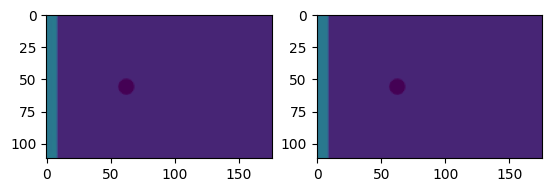

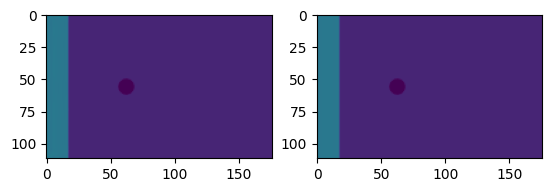

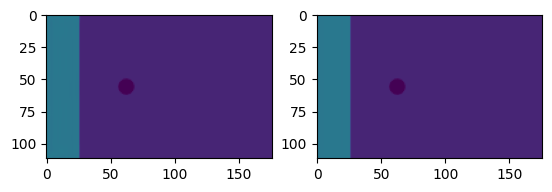

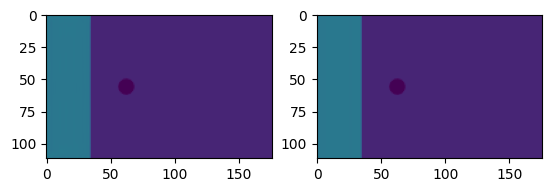

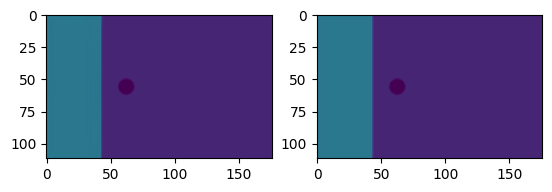

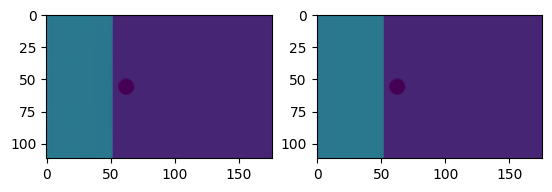

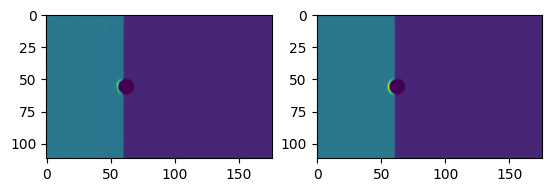

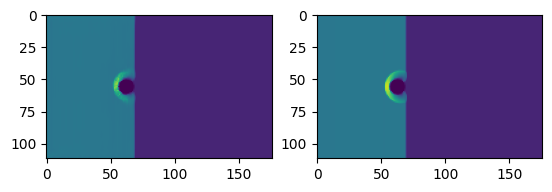

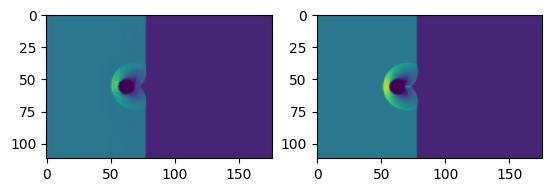

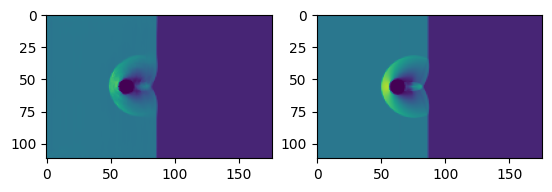

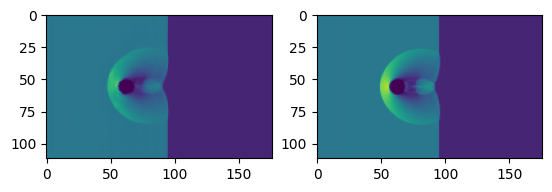

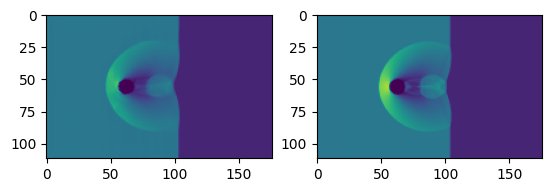

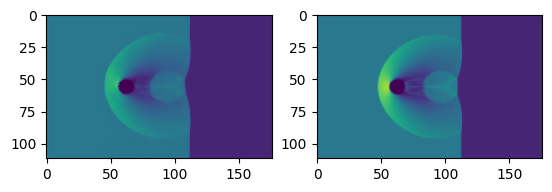

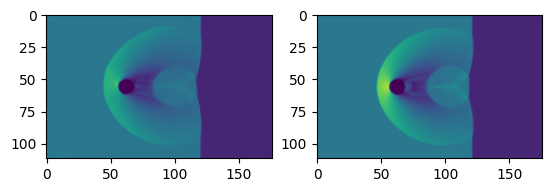

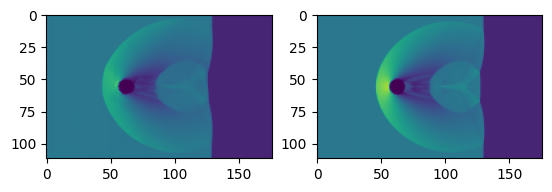

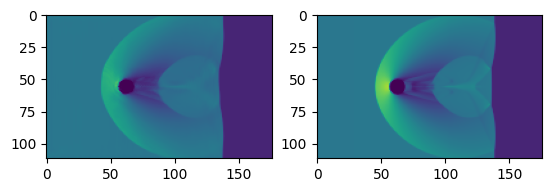

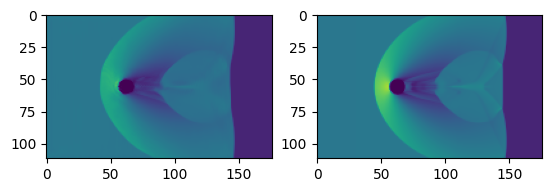

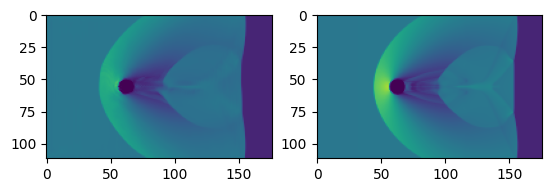

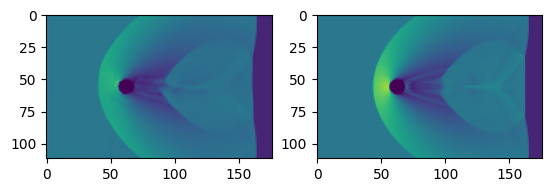

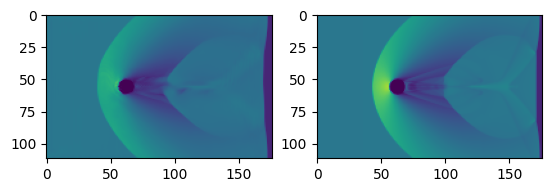

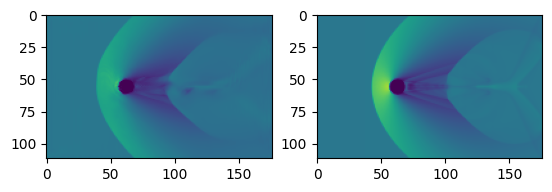

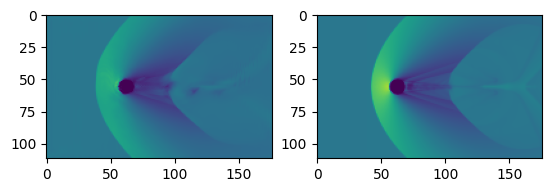

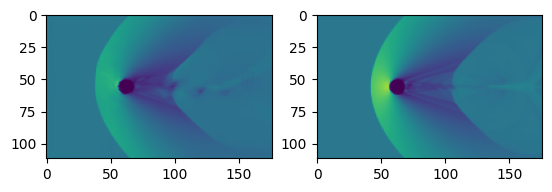

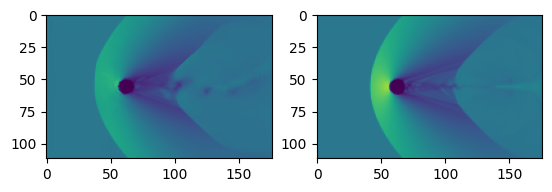

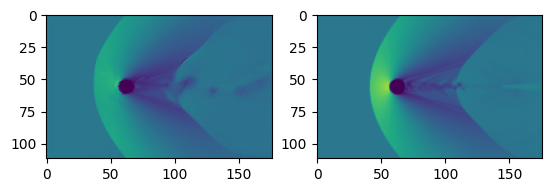

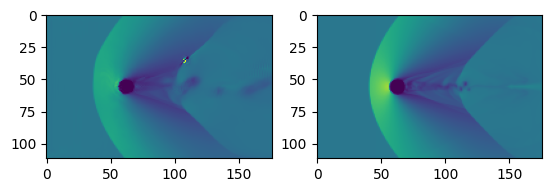

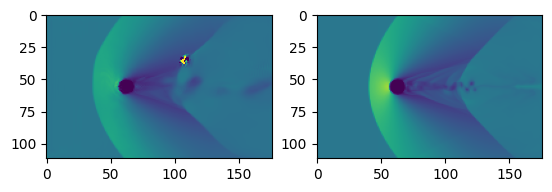

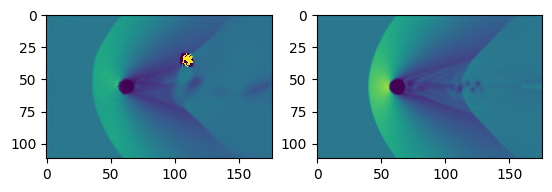

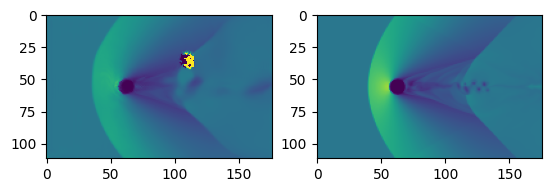

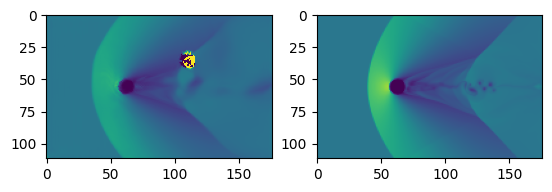

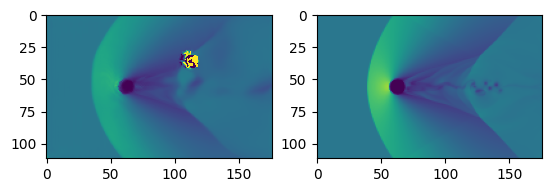

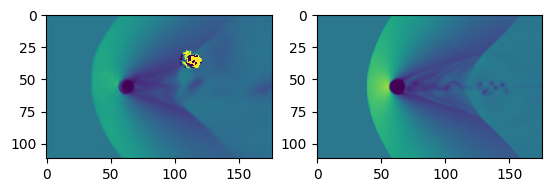

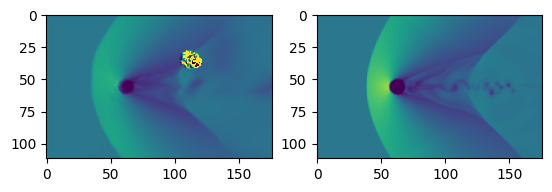

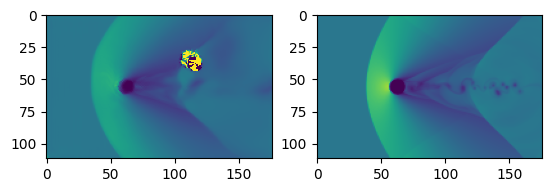

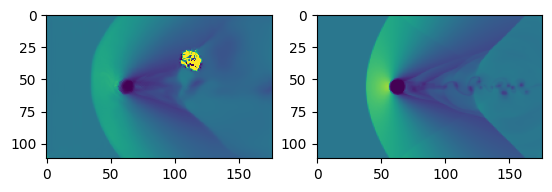

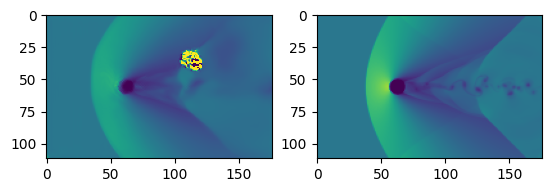

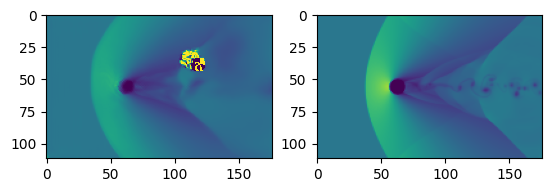

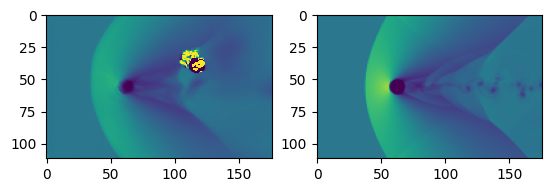

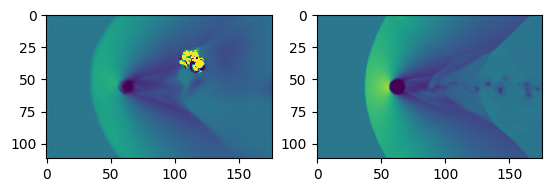

In [29]:
for i in range(39):
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(state_pred[0,:,:,i*2],vmin = 0, vmax=np.amax(state_seq[idx,:,:,0::2]))
    ax[1].imshow(state_seq[idx,:,:,i*2+2],vmin = 0, vmax=np.amax(state_seq[idx,:,:,0::2]))
    plt.show()